In [1]:
import numpy as np
import os
from pyexcel_ods import get_data
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from statistics import ceil_to_decimal

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

In [2]:
gtfile = "./datasets/train_val_test_files/visible_pixel_ratios_rgb_xyz.ods"
testimgdir = "./datasets/train_val_test_files/orcnn/test/PNGImages"

gt = get_data(gtfile)

data_combined = np.zeros((2560, 16), dtype = object)
counter = 0
all_plant_ids = []

In [3]:
if os.path.isdir(testimgdir):
    all_files = os.listdir(testimgdir)
    testimages = [x.split(".png")[0] for x in all_files if "rgb" in x and ".png" in x]

In [4]:
for k in range(1, len(gt['visible_pixel_ratios'])):
    gt_data = gt['visible_pixel_ratios'][k]
    if gt_data:
        if gt_data[0] != "image_name":
            img_name = gt_data[0]
            
            if "plant" in img_name:
                basename, fileext = os.path.splitext(img_name)
                plant_id = int(basename.split("_")[2].split("plant")[1])
                all_plant_ids.append(plant_id)

unique_plant_ids = list(set(all_plant_ids))
unique_plant_ids.sort()

trigger_ids = []
for j in range(len(unique_plant_ids)):
    trigger_ids.append([])

In [5]:
for k in range(1, len(gt['visible_pixel_ratios'])):
    gt_data = gt['visible_pixel_ratios'][k]
    if gt_data:
        if gt_data[0] != "image_name":
            img_name = gt_data[0]

            if "plant" in img_name:
                basename, fileext = os.path.splitext(img_name)
                plant_id = int(basename.split("_")[2].split("plant")[1])
                trigger_id = int(basename.split("_")[4].split("trigger")[1])
                
                idx = np.where(np.asarray(unique_plant_ids) == plant_id)[0][0]
                trigger_ids[idx].append(trigger_id)

first_trigger_numbers = []

for j in range(len(trigger_ids)):
    first_trigger_numbers.append(np.min(trigger_ids[j]))

In [6]:
for k in range(1, len(gt['visible_pixel_ratios'])):
    gt_data = gt['visible_pixel_ratios'][k]
    if gt_data:
        if gt_data[0] != "image_name":
            img_name = gt_data[0]
            occluded_pixels_rgb = gt_data[1]
            vpr_rgb = gt_data[2]
            nonoccluded_pixels_rgb = gt_data[3]
            occluded_pixels_xyz = gt_data[4]
            vpr_xyz = gt_data[5]
            pixel_diff = gt_data[6]
            vpr_diff = gt_data[7]
            
            basename, fileext = os.path.splitext(img_name)
            
            if basename in testimages:
                testimg = 1
            else:
                testimg = 0

            if "plant" in img_name:
                plant_id = int(basename.split("_")[2].split("plant")[1])
                trigger_id = int(basename.split("_")[4].split("trigger")[1])
                
                idx = np.where(np.asarray(unique_plant_ids) == plant_id)[0][0]
                
                first_trigger = first_trigger_numbers[idx]
                
                if trigger_id == first_trigger:
                    simulated_occlusion = 0
                    ocr_string = "Natural occlusion"
                else:
                    simulated_occlusion = 1
                    ocr_string = "Man-made occlusion"
                    
                sensor = "Realsense D435"
                sensor_id = 1
            else:
                sensor = "Ensenso N35"
                sensor_id = 0
                simulated_occlusion = 0
                ocr_string = "Natural occlusion"

            data_combined[counter, 0] = img_name
            data_combined[counter, 1] = int(occluded_pixels_rgb)
            data_combined[counter, 2] = float(vpr_rgb)
            data_combined[counter, 3] = float(1-vpr_rgb)
            data_combined[counter, 4] = round(ceil_to_decimal(float(1-vpr_rgb)), 1)
            data_combined[counter, 5] = int(nonoccluded_pixels_rgb)
            data_combined[counter, 6] = int(occluded_pixels_xyz)
            data_combined[counter, 7] = float(vpr_xyz)
            data_combined[counter, 8] = int(pixel_diff)
            data_combined[counter, 9] = float(vpr_diff)
            data_combined[counter, 10] = float(pixel_diff)/float(occluded_pixels_rgb)
            data_combined[counter, 11] = sensor
            data_combined[counter, 12] = int(sensor_id)
            data_combined[counter, 13] = int(simulated_occlusion)
            data_combined[counter, 14] = ocr_string
            data_combined[counter, 15] = int(testimg)
            counter = counter+1

In [7]:
df = pd.DataFrame(data=data_combined, columns=["name", "pixels_rgb", "vpr_rgb", "ocr_rgb", "ocr", "total_pixels_rgb", "pixels_xyz", "vpr_xyz", "pixel_diff", "vpr_diff", "pixel_loss", "sensor", "sensor_id", "simulated_occlusion", "ocr_string", "testimage"])

In [8]:
df["simulated_occlusion"] = df["simulated_occlusion"].astype(int)
df["ocr_rgb"] = df["ocr_rgb"].astype(float)
ocrs_list = df.groupby(["simulated_occlusion"])["ocr_rgb"].apply(list)
natural_ocrs = ocrs_list[0]
simulated_ocrs = ocrs_list[1]

print("Natural occlusion rates")
print("n = {0:d}".format(len(natural_ocrs)))
print("Mean OCR: {0:.3f}".format(np.mean(natural_ocrs)))
print("STD OCR: {0:.3f}".format(np.std(natural_ocrs)))
print("")

print("Simulated occlusion rates")
print("n = {0:d}".format(len(simulated_ocrs)))
print("Mean OCR: {0:.3f}".format(np.mean(simulated_ocrs)))
print("STD OCR: {0:.3f}".format(np.std(simulated_ocrs)))

Natural occlusion rates
n = 1197
Mean OCR: 0.259
STD OCR: 0.236

Simulated occlusion rates
n = 1363
Mean OCR: 0.449
STD OCR: 0.303


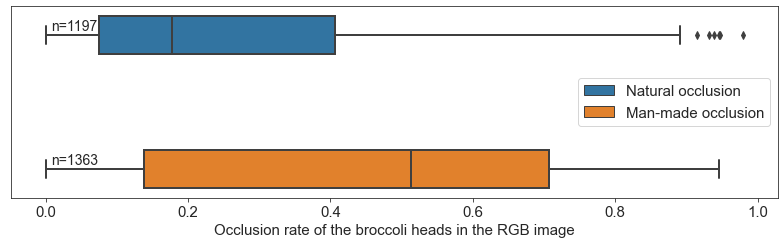

In [9]:
writedir = "./results"

font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="ocr_rgb", y="simulated_occlusion", hue="ocr_string", orient="h", linewidth=2, data=df)

ax.set_ylabel('')
plt.legend(loc='center right', fontsize=font_size)

plt.xlabel('Occlusion rate of the broccoli heads in the RGB image', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks([])

plt.annotate('n={:.0f}'.format(len(natural_ocrs)), (0.008, -0.25), fontsize=annot_size)
plt.annotate('n={:.0f}'.format(len(simulated_ocrs)), (0.008, 1.15), fontsize=annot_size)

plt.tight_layout()
plt.savefig(os.path.join(writedir, 'natural_and_simulated_ocrs.png'))
plt.show()

In [10]:
unique_ocrs = list(set(df["ocr"]))
unique_ocrs.sort()
ocr_counts = np.zeros(len(unique_ocrs)).astype(np.uint8)

x_ticks_list = []

In [11]:
sel_ocr1 = df['ocr_rgb'] >= 0.5
sel_ocr2 = df['ocr_rgb'] < 0.9
sel_ocr3 = df['ocr_rgb'] < 0.5
testimg = df['testimage'] == 1
simulated = df['simulated_occlusion'] == 1
natural = df['simulated_occlusion'] == 0

print("Number of testimages with a natural OCR:" + str(len(df[testimg & natural])))
print("Number of testimages with between the OCR bounds:" + str(len(df[sel_ocr1 & sel_ocr2 & testimg])))
print("Number of testimages with a significantly higher simulated OCR:" + str(len(df[sel_ocr1 & sel_ocr2 & simulated & testimg])))
print("Number of testimages with a significantly higher natural OCR:" + str(len(df[sel_ocr1 & sel_ocr2 & natural & testimg])))

Number of testimages with a natural OCR:199
Number of testimages with between the OCR bounds:161
Number of testimages with a significantly higher simulated OCR:127
Number of testimages with a significantly higher natural OCR:34


In [12]:
df["pixel_loss"] = df["pixel_loss"].astype(float)

print("Pixel loss on the depth image after RGB-D registration")
print("n = {0:d}".format(2560))
print("Mean pixel loss: {0:.3f}".format(df["pixel_loss"].mean()))
print("STD pixel loss: {0:.3f}".format(df["pixel_loss"].std()))

Pixel loss on the depth image after RGB-D registration
n = 2560
Mean pixel loss: 0.202
STD pixel loss: 0.199


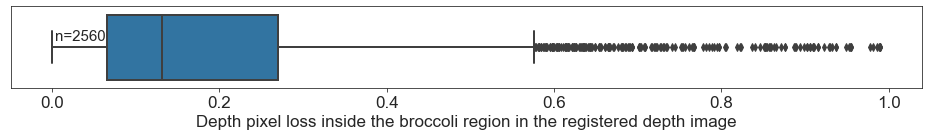

In [13]:
font_size = 17
digit_size = 15
annot_size = 15

sns.set_style("ticks")
f, ax = plt.subplots(figsize=(13, 2))

ax = sns.boxplot(x="pixel_loss", hue="pixel_loss", orient="h", linewidth=2, data=df)
ax.set_ylabel('')

plt.xlabel('Depth pixel loss inside the broccoli region in the registered depth image', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks([])

plt.annotate('n={:.0f}'.format(2560), (0.004, -0.08),  fontsize=annot_size)

plt.tight_layout()
plt.savefig(os.path.join(writedir, 'pixel_loss_depth_image.png'))
plt.show()

In [14]:
df["pixel_loss"] = df["pixel_loss"].astype(float)

print("Pixel loss on the depth image after RGB-D registration")
print("n = {0:d}".format(2560))
print(df.groupby('sensor_id').mean()['pixel_loss'])
print(df.groupby('sensor_id').std()['pixel_loss'])

Pixel loss on the depth image after RGB-D registration
n = 2560
sensor_id
0    0.174771
1    0.217417
Name: pixel_loss, dtype: float64
sensor_id
0    0.177316
1    0.209343
Name: pixel_loss, dtype: float64


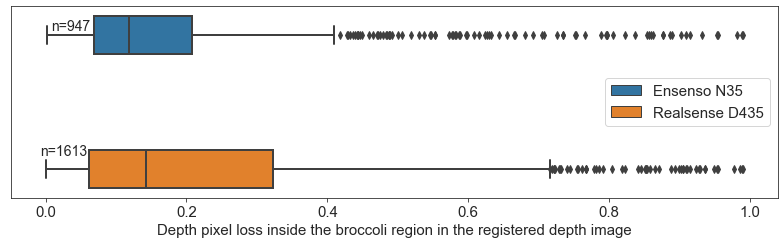

In [15]:
font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="pixel_loss", y="sensor_id", hue="sensor", orient="h", linewidth=2, data=df)
ax.set_ylabel('')
plt.legend(loc='center right', fontsize=font_size)

plt.xlabel('Depth pixel loss inside the broccoli region in the registered depth image', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks([])

plt.annotate('n={:.0f}'.format(df.groupby(['sensor_id']).size()[0]), (0.008, -0.25), fontsize=annot_size)
plt.annotate('n={:.0f}'.format(df.groupby(['sensor_id']).size()[1]), (-0.008, 1.05), fontsize=annot_size)

plt.tight_layout()
plt.savefig(os.path.join(writedir, 'pixel_loss_depth_image_per_device.png'))
plt.show()